In [9]:
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import imshow, figure, bar, hist, show
from skimage.measure import compare_ssim as ssim
from skimage import io
from skimage import exposure
from skimage.transform import resize
from skimage.util import img_as_ubyte

import imagehash
from PIL import Image
import numpy as np
from shutil import copyfile

import plotly.plotly as py
from plotly.graph_objs import *

In [10]:
DebugImage = True

PATH_TO_TRAIN = "../../data/input/data_stage1_train.zip"

In [11]:
images_to_process = []

for current_directory in os.listdir(PATH_TO_TRAIN):
    current_image = {}
    current_image["id"] = current_directory
    current_image["images"] = []
    current_image["masks"] = []
    for current_image_file in os.listdir(os.path.join(PATH_TO_TRAIN,current_directory,"images")):
        current_image["images"].append(os.path.join(PATH_TO_TRAIN,current_directory,"images", current_image_file))
    
    for current_image_mask in os.listdir(os.path.join(PATH_TO_TRAIN,current_directory,"masks")):
        current_image["masks"].append(os.path.join(PATH_TO_TRAIN,current_directory,"masks", current_image_mask))
   
    images_to_process.append(current_image)

In [12]:
layout = Layout(
    title='Parametric Plot',
    scene=Scene(
        xaxis=XAxis(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=YAxis(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=ZAxis(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

/home/ubuntu/git/kaggle.Bowl.Nuclei/env/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning:

Possible precision loss when converting from float64 to uint8



(19, 19) 11 160 149
(19, 19) 0.0 255.0 255.0


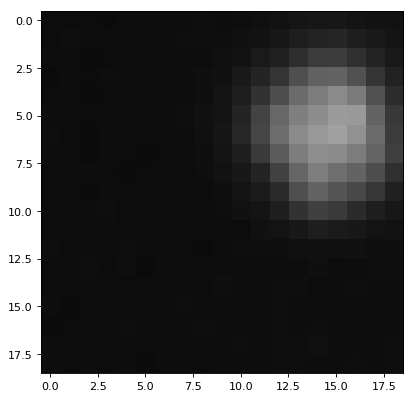

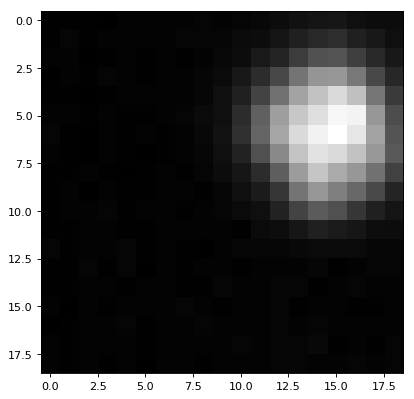

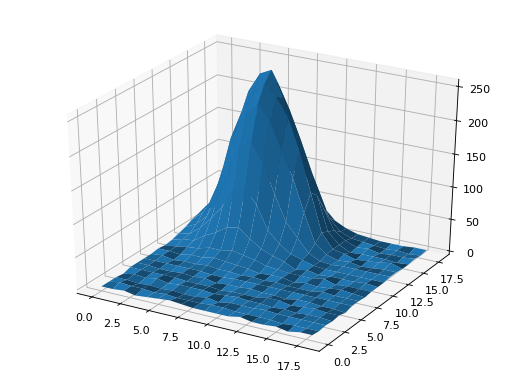

In [13]:
%matplotlib inline
    
for current_image in images_to_process:
    file_png = io.imread(current_image['images'][0], as_grey=True) 
    file_png = file_png[1:20,1:20]
    file_png = img_as_ubyte(file_png)

    array1 = np.asarray(file_png)
    min_value = array1.min()
    max_value = array1.max()
    current_range = max_value - min_value
    
    #Original Image
    if DebugImage:
        print(array1.shape, min_value,max_value, current_range)
        figure(figsize=(8, 6), dpi=80)
        imshow(array1, cmap='gray',vmin=0,vmax=255)

    #Normalized Image
    file_png = file_png - min_value
    file_png = file_png * (255 / current_range )
    array1 = np.asarray(file_png)
    min_value = array1.min()
    max_value = array1.max()
    current_range = max_value - min_value
    if DebugImage:
        print(array1.shape, min_value,max_value, current_range)
        figure(figsize=(8, 6), dpi=80)
        imshow(array1, cmap='gray',vmin=0,vmax=255)

    #Surface Plot
    if DebugImage:
        fig = figure(figsize=(8, 6), dpi=80)
        ax = fig.gca(projection='3d')
        X, Y = np.meshgrid(np.arange(0, array1.shape[0]) ,  np.arange(0,array1.shape[1]))
        Z = np.array(array1[X, Y])
        surf = ax.plot_surface(X , Y, Z)
        show()
    
    break
    
